<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumToyAlgorithm_Bernstein%E2%80%93Vazirani__01_GoogleAIStudio_mkbahk_20250414.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.8 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=c8c3bcc991ce9cdd86bce4eed7a47a03009eec904358c3c7d993ee1a4ca6b07f
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.1 MB/s eta 0:00:00
  Cloning https://github.com/qisk

In [61]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit_aer import Aer
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

In [87]:
# --- 1. 숨겨진 문자열 정의 ---
# 예시: '1101' (길이 n=4)
hidden_string = '1101'
n = len(hidden_string)

# Qiskit은 리틀 엔디안(little-endian)을 사용하므로,
# s = s_{n-1}...s_1s_0 형태가 자연스러움.
# hidden_string '1101'은 s_3=1, s_2=1, s_1=0, s_0=1 을 의미
# 오라클 구현 시 문자열을 뒤집어 사용하는 것이 편리할 수 있음
s_reversed = hidden_string[::-1] # '1011' (s_0=1, s_1=0, s_2=1, s_3=1)

# --- 2. 양자 회로 생성 ---
# n개의 입력 큐비트 + 1개의 보조 큐비트
# n개의 클래식 비트 (측정 결과 저장용)
bv_circuit = QuantumCircuit(n + 1, n)

# --- 3. 알고리즘 단계 구현 ---

# 단계 1: 보조 큐비트를 |1> 상태로 초기화 (X 게이트 적용)
bv_circuit.x(n) # n번 큐비트가 보조 큐비트

# 단계 2: 모든 큐비트에 아다마르 게이트 적용
for i in range(n + 1):
    bv_circuit.h(i)
###for

bv_circuit.barrier() # 시각적 분리

# 단계 3: 양자 오라클 구현 (U_f)
# f(x) = s . x (mod 2)
# 이는 s_i = 1 인 모든 i에 대해 입력 큐비트 i와 보조 큐비트 n 사이에 CNOT 게이트를 적용하는 것과 같음
for i in range(n):
    if s_reversed[i] == '1': # s_i가 1이면
        bv_circuit.cx(i, n) # i번 큐비트 (control) -> n번 큐비트 (target)
    ###if
###for

bv_circuit.barrier() # 시각적 분리

# 단계 4: 입력 큐비트에 다시 아다마르 게이트 적용
for i in range(n):
    bv_circuit.h(i)
###for

# 단계 5: 입력 큐비트 측정
# 측정 결과를 클래식 비트에 저장 (큐비트 0~n-1 -> 클래식 비트 0~n-1)
bv_circuit.measure(range(n), range(n))

# --- 4. 회로 시각화 (선택 사항) ---
print("Bernstein-Vazirani 회로:")
print(bv_circuit)

# --- 5. 시뮬레이션 실행 ---
simulator = Aer.get_backend("qasm_simulator")
compiled_circuit = transpile(bv_circuit, simulator)

# 이론적으로 1샷이면 충분하지만, 확인을 위해 여러 샷 실행 가능
shots = 1024
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts(bv_circuit)

# --- 6. 결과 출력 및 확인 ---
print("\n숨겨진 문자열 s:", hidden_string)
print(f"시뮬레이션 결과 ({shots} shots):", counts)

# 가장 확률이 높은 결과 추출
measured_string = max(counts, key=counts.get)
# Qiskit 결과는 리틀 엔디안이므로 다시 뒤집어 원래 순서로 만듦
recovered_string = measured_string[::-1]

print("\n측정을 통해 복구된 문자열:", recovered_string)

if recovered_string == hidden_string:
    print("성공: 숨겨진 문자열을 정확히 찾았습니다!")
else:
    print("실패: 숨겨진 문자열과 다릅니다.")
###for


Bernstein-Vazirani 회로:
     ┌───┐      ░                 ░ ┌───┐┌─┐         
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├─────────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├──────░───┼─────────────░─┤ H ├─╫─┤M├──────
     ├───┤      ░   │             ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├──────░───┼────■────────░─┤ H ├─╫──╫─┤M├───
     ├───┤      ░   │    │        ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░───┼────┼────■───░─┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░───────╫──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░       ║  ║  ║  ║ 
c: 4/═════════════════════════════════════╩══╩══╩══╩═
                                          0  1  2  3 

숨겨진 문자열 s: 1101
시뮬레이션 결과 (1024 shots): {'1101': 1024}

측정을 통해 복구된 문자열: 1011
실패: 숨겨진 문자열과 다릅니다.


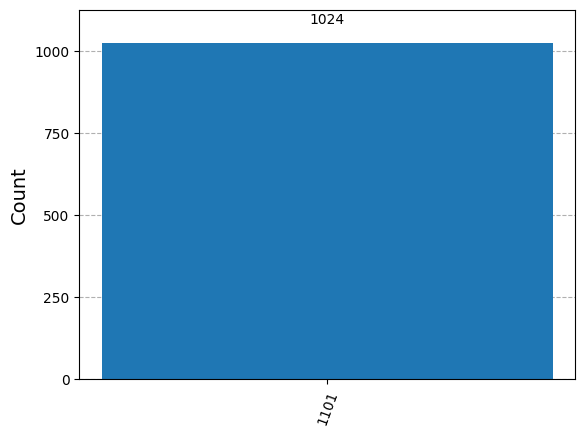

In [88]:
# 결과 히스토그램 시각화
plot_histogram(counts)